In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf ManTraNet
!git clone https://github.com/ISICV/ManTraNet.git


Cloning into 'ManTraNet'...
remote: Enumerating objects: 202, done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 202
Receiving objects: 100% (202/202), 139.99 MiB | 43.99 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [0]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot


In [0]:
manTraNet_root = './ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

In [5]:
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

INFO: in total, load 72 samples


In [6]:
import modelCore
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.




INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True











In [7]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

Model: "sigNet"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNorm

In [8]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

Model: "Featex"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymP

In [0]:
from datetime import datetime 
def read_rgb_image( image_file ) :
    rgb = cv2.imread( image_file, 1 )[...,::-1]
    return rgb
    
def decode_an_image_array( rgb, manTraNet, dn=1 ) :
    x = np.expand_dims( rgb.astype('float32')/255.*2-1, axis=0 )[:,::dn,::dn]
    t0 = datetime.now()
    y = manTraNet.predict(x)[0,...,0]
    t1 = datetime.now()
    return y, t1-t0

def decode_an_image_file( image_file, manTraNet, dn=1 ) :
    rgb = read_rgb_image( image_file )
    mask, ptime = decode_an_image_array( rgb, manTraNet, dn )
    return rgb[::dn,::dn], mask, ptime.total_seconds()

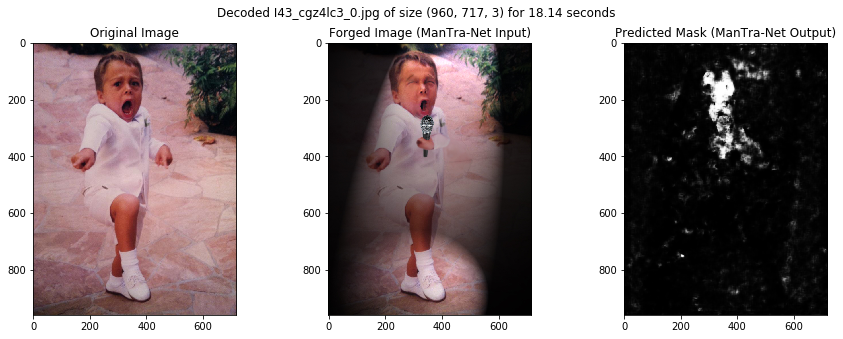

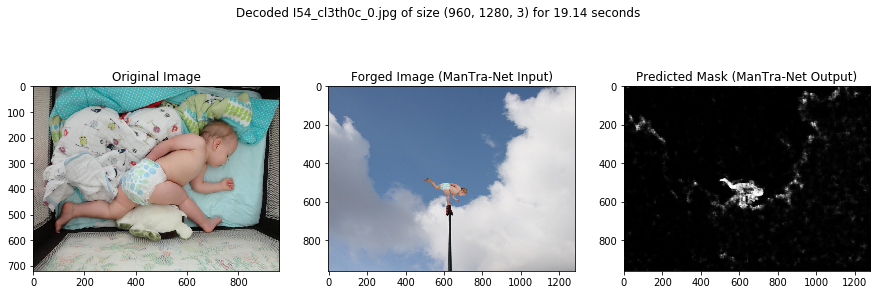

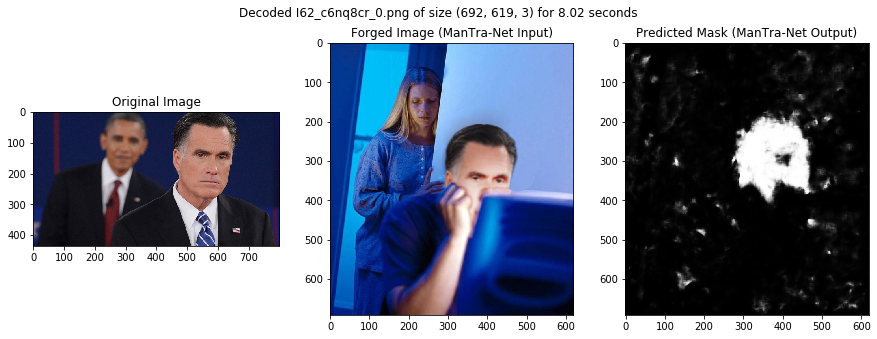

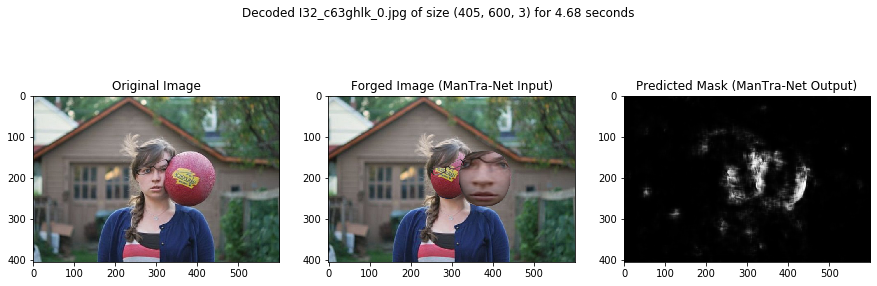

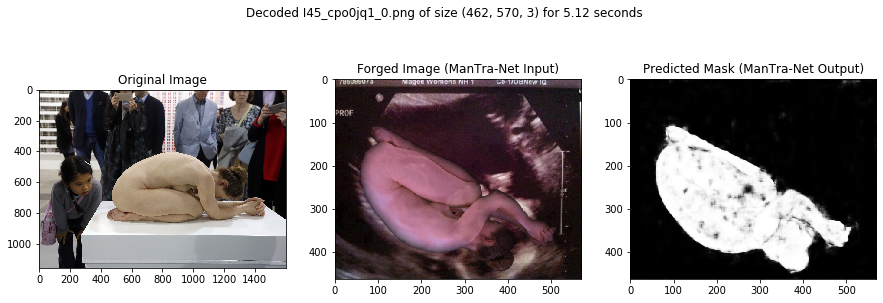

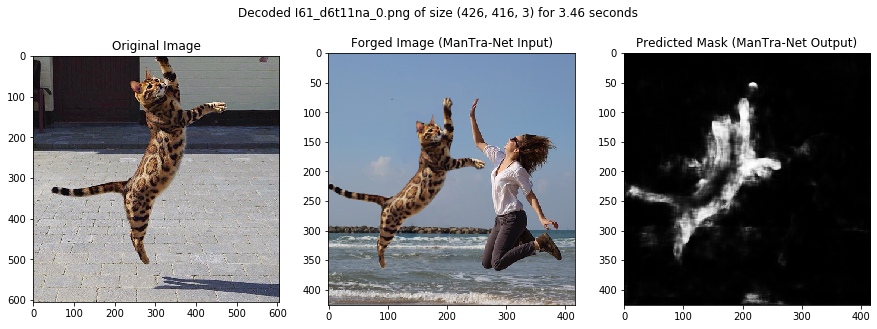

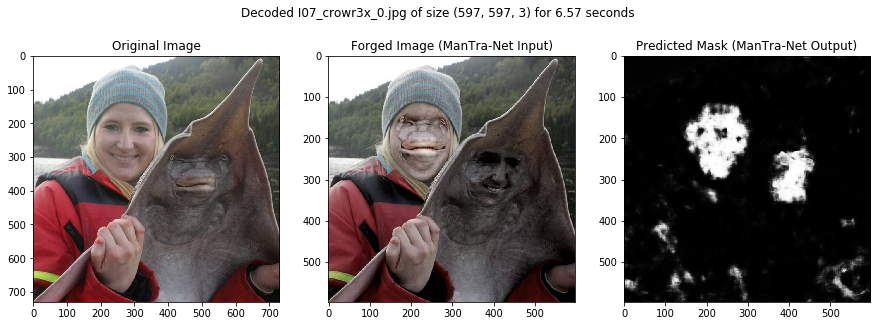

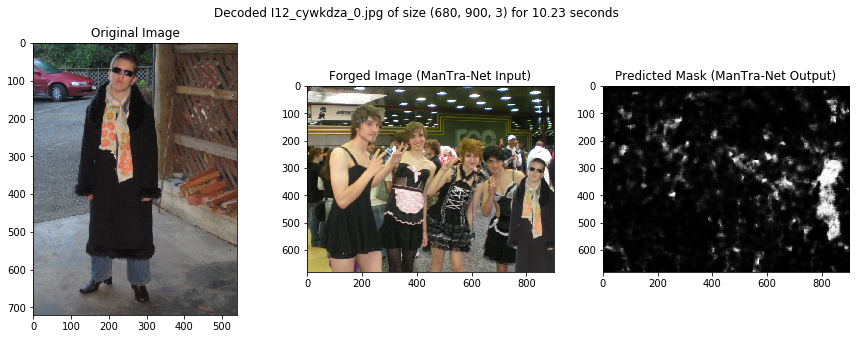

In [10]:
for k in range(8) :
    # get a sample
    forged_file, original_file = get_a_random_pair()
    # load the original image just for reference
    ori = read_rgb_image( original_file )
    # manipulation detection using ManTraNet
    rgb, mask, ptime = decode_an_image_file( forged_file, manTraNet ) 
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.subplot(131)
    pyplot.imshow( ori )
    pyplot.title('Original Image')
    pyplot.subplot(132)
    pyplot.imshow( rgb )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(133)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( os.path.basename( forged_file ), rgb.shape, ptime ) )
    pyplot.show()

In [0]:
def get_image_from_url(url, xrange=None, yrange=None, dn=1) :
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    if img.shape[-1] > 3 :
        img = img[...,:3]
    ori = np.array(img)
    if xrange is not None :
        img = img[:,xrange[0]:xrange[1]]
    if yrange is not None :
        img = img[yrange[0]:yrange[1]]
    mask, ptime =  decode_an_image_array( img, manTraNet, dn )
    ptime = ptime.total_seconds()
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.title('Original Image')
    pyplot.subplot(131)
    pyplot.imshow( img )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(132)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.subplot(133)
    pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
    pyplot.title('Highlighted Forged Regions')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
    pyplot.show()
    

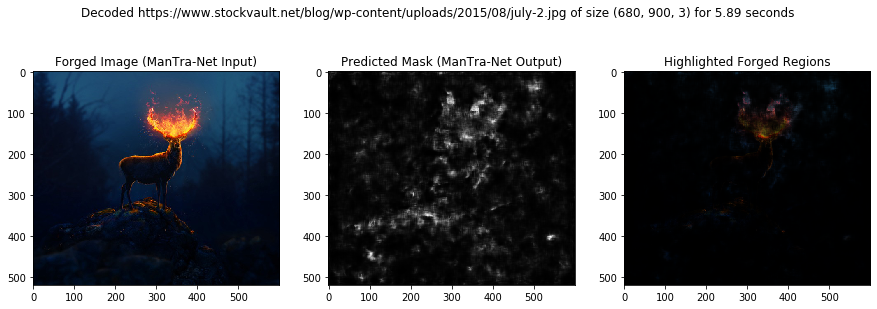

In [12]:
get_image_from_url('https://www.stockvault.net/blog/wp-content/uploads/2015/08/july-2.jpg')

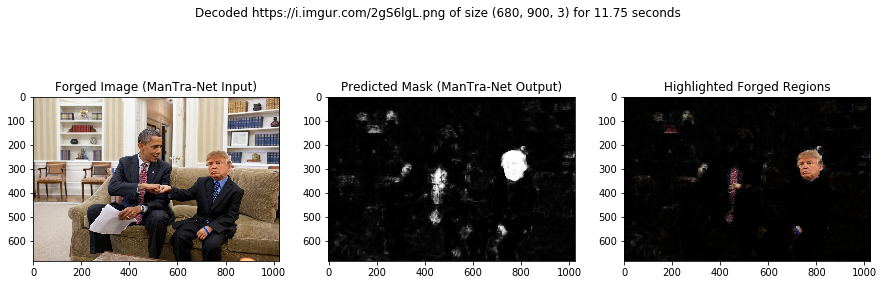

In [13]:
 get_image_from_url('https://i.imgur.com/2gS6lgL.png')

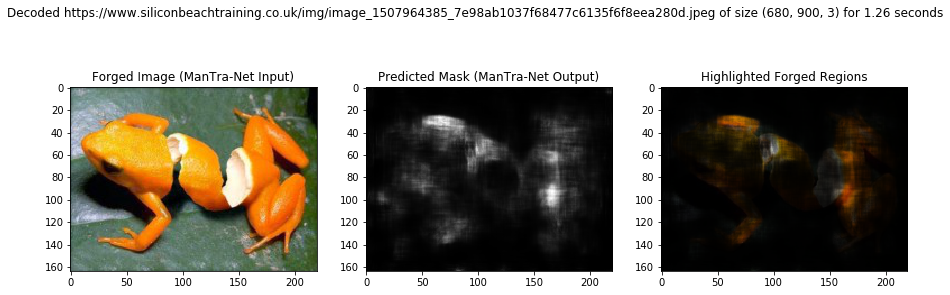

In [14]:
get_image_from_url('https://www.siliconbeachtraining.co.uk/img/image_1507964385_7e98ab1037f68477c6135f6f8eea280d.jpeg')

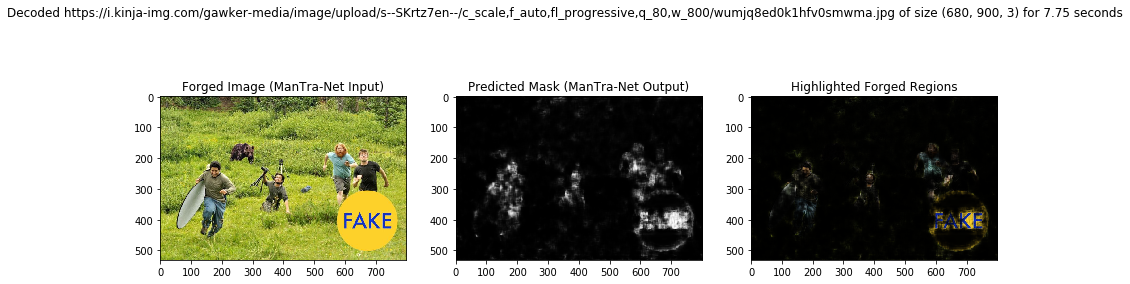

In [15]:
get_image_from_url('https://i.kinja-img.com/gawker-media/image/upload/s--SKrtz7en--/c_scale,f_auto,fl_progressive,q_80,w_800/wumjq8ed0k1hfv0smwma.jpg')

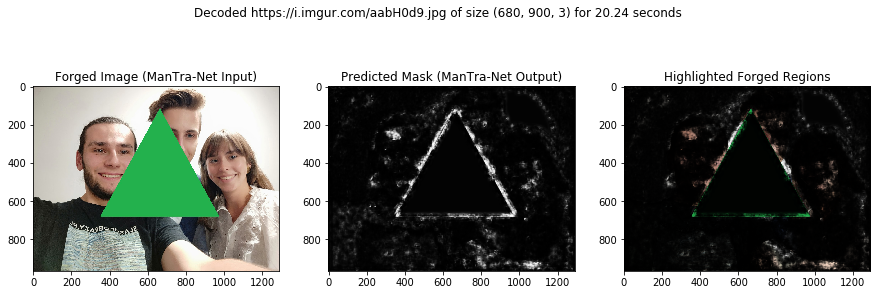

In [16]:
get_image_from_url('https://i.imgur.com/aabH0d9.jpg')

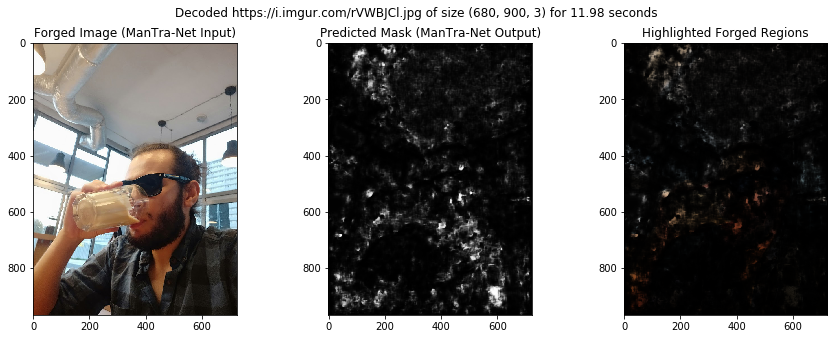

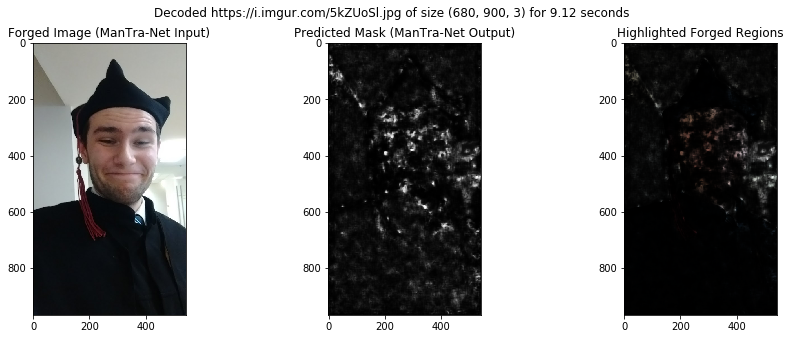

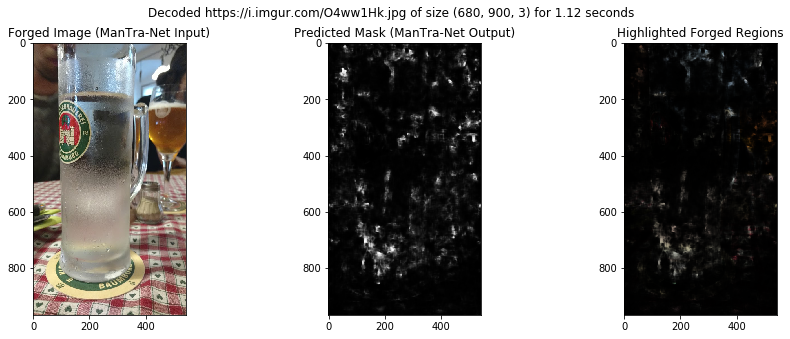

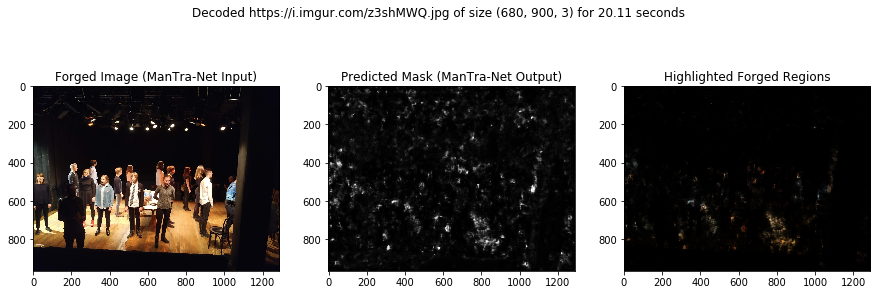

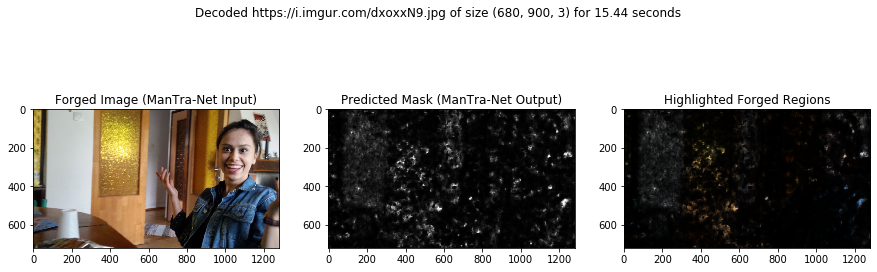

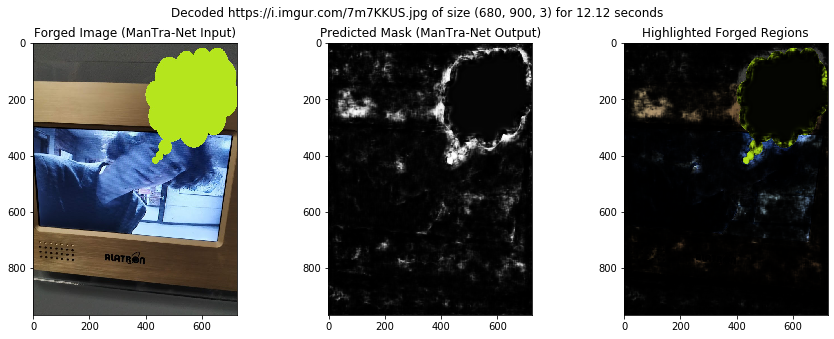

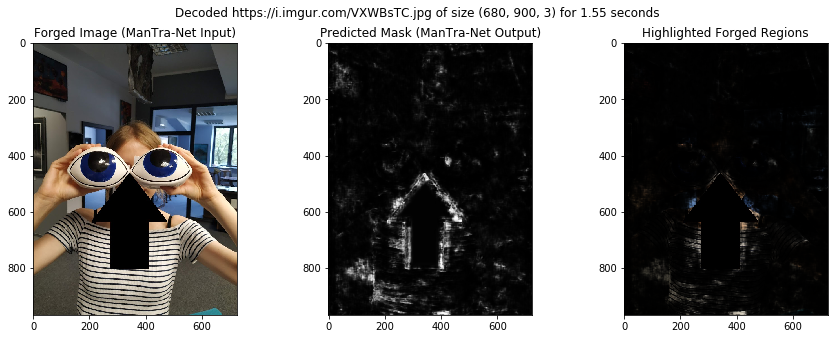

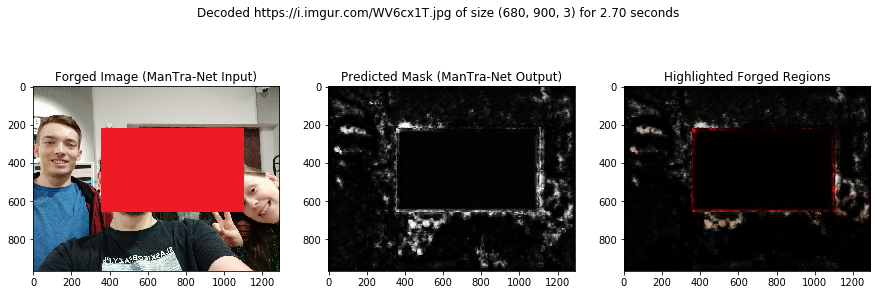

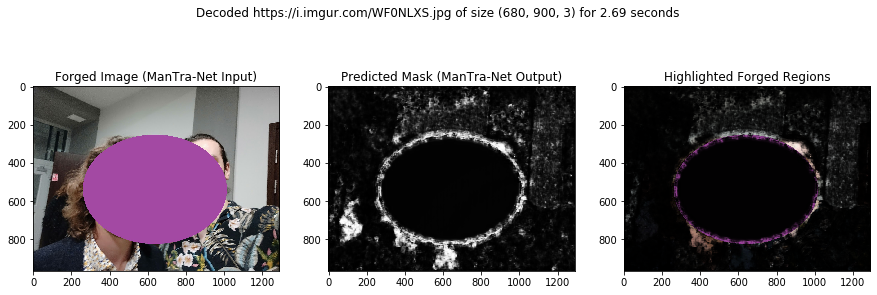

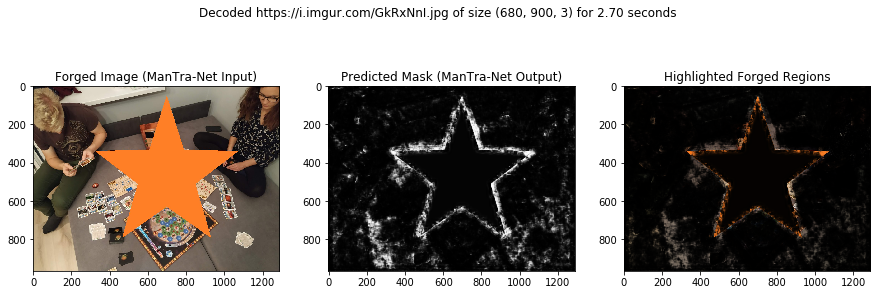

In [20]:
# Org
org = [
  'https://i.imgur.com/rVWBJCl.jpg',
  'https://i.imgur.com/5kZUoSl.jpg',
  'https://i.imgur.com/O4ww1Hk.jpg',
  'https://i.imgur.com/z3shMWQ.jpg',
  'https://i.imgur.com/dxoxxN9.jpg'
]

# Ps
ps = [
  'https://i.imgur.com/7m7KKUS.jpg',
  'https://i.imgur.com/VXWBsTC.jpg',
  'https://i.imgur.com/WV6cx1T.jpg',
  'https://i.imgur.com/WF0NLXS.jpg',
  'https://i.imgur.com/GkRxNnI.jpg'
]

for img in org:
  get_image_from_url(img)

for img in ps:
  get_image_from_url(img)